In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix,csr_matrix
from tensorflow.keras.layers import Embedding

# Reading the Data

### data is taken from https://www.kaggle.com/aiswaryaramachandran/hindienglish-corpora
### data have three column source, english_sentence, hindi_sentence

In [2]:
df=pd.read_csv('Hindi_English_Truncated_Corpus.csv')

## extracting details about data

In [3]:
df.shape

(127607, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127607 entries, 0 to 127606
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   source            127607 non-null  object
 1   english_sentence  127605 non-null  object
 2   hindi_sentence    127607 non-null  object
dtypes: object(3)
memory usage: 2.9+ MB


## dropping na values

In [5]:
df=df.dropna()

In [6]:
df.shape

(127605, 3)

## dropping duplicates

In [7]:
df=df.drop_duplicates()

In [8]:
df.shape

(124827, 3)

In [9]:
df.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [10]:
df['hindi_sentence'].values[124824]

'जहां तक गंधक के अन्य उत्पादों का प्रश्न है , देश में लोहे , तांबे , सोडियम , सल्फेट आदि की आवश्यकता सीमित थी और युद्धोपरांत हुआ उत्पादन सामान्य रूप से पर्याप्त था .'

In [11]:
df['hindi_sentence'].values[124824][36]+df['hindi_sentence'].values[124824][37]+df['hindi_sentence'].values[124824][38]

'श्न'

## doing some preprocessing on text data

In [12]:
import re
def preprocess(data_x):
    data1=[]
    for data in tqdm(data_x):
        
        data=data.replace('\\r','').replace('\\n','').replace('\\',' ').replace("n\'t",' not').replace(',',' ')\
        .replace('.',' ').replace('%',' ').replace("'s",' is').replace('-',' ').replace('"','').replace('_','').replace(':','')\
        .replace(';','').replace('!','').replace('!!','').replace(';','').replace('/',' ').replace('?',' ').replace('  ',' ')\
        .replace('।','')

        p = re.compile('[0-9]+')
        data=p.sub('', data)

        data = re.sub(r"won't", "will not", data)
        data = re.sub(r"can\'t", "can not", data)

        # general
        data = re.sub(r"n\'t", " not", data)
        data = re.sub(r"\'re", " are", data)
        data = re.sub(r"\'s", " is", data)
        data = re.sub(r"\'d", " would", data)
        data = re.sub(r"\'ll", " will", data)
        data = re.sub(r"\'t", " not", data)
        data = re.sub(r"\'ve", " have", data)
        data = re.sub(r"\'m", " am", data)

#         data = ' '.join(e for e in data.split() if e.lower() not in stopwords)
        data=data.lower()
        data=' '.join(data.split())
        data1.append(data)
    return data1
    

In [13]:
df['english_sentence']=preprocess(df['english_sentence'].values)

100%|███████████████████████████████████████████████████████████████████████| 124827/124827 [00:02<00:00, 49226.21it/s]


In [14]:
df.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,i would like to tell you about one such child,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,this percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they are bad at no...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,the ending portion of these vedas is called up...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [15]:
df['hindi_sentence']=preprocess(df['hindi_sentence'].values)

100%|███████████████████████████████████████████████████████████████████████| 124827/124827 [00:02<00:00, 42139.20it/s]


In [16]:
df.head().values

array([['ted',
        'politicians do not have permission to do what needs to be done',
        'राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करने कि अनुमति नहीं है'],
       ['ted', 'i would like to tell you about one such child',
        'मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी'],
       ['indic2012',
        'this percentage is even greater than the percentage in india',
        'यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है'],
       ['ted',
        'what we really mean is that they are bad at not paying attention',
        'हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते'],
       ['indic2012',
        'the ending portion of these vedas is called upanishad',
        'इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है']], dtype=object)

## keeping sentence which have only less than 25 words

In [17]:
keeping_data=[]
for i,val in tqdm(enumerate(df.values)):
    #print(i,val)
    if len(val[1].split(' '))<=25:
        keeping_data.append(val)
    
#     break

124827it [00:00, 463498.95it/s]


In [18]:
len(keeping_data)

105129

In [19]:
df=pd.DataFrame(keeping_data,columns=['source','english_sentence','hindi_sentence'])

In [20]:
df.shape

(105129, 3)

In [21]:
keeping_data=[]
for i,val in tqdm(enumerate(df.values)):
    #print(i,val)
    if len(val[2].split(' '))<=25:
        keeping_data.append(val)

105129it [00:00, 444769.78it/s]


In [22]:
df=pd.DataFrame(keeping_data,columns=['source','english_sentence','hindi_sentence'])

In [23]:
df.shape

(97838, 3)

## encoding text so that we can input it in encoder-decoder model

In [24]:
# df['decoder_input_hin']='<start> '+df['hindi_sentence']
df['hindi_sentence']='<start> '+df['hindi_sentence']+' <end>'
df['english_sentence']=df['english_sentence']+' eos'

In [25]:
df.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,<start> राजनीतिज्ञों के पास जो कार्य करना चाहि...
1,ted,i would like to tell you about one such child eos,<start> मई आपको ऐसे ही एक बच्चे के बारे में बत...
2,indic2012,this percentage is even greater than the perce...,<start> यह प्रतिशत भारत में हिन्दुओं प्रतिशत स...
3,ted,what we really mean is that they are bad at no...,<start> हम ये नहीं कहना चाहते कि वो ध्यान नहीं...
4,indic2012,the ending portion of these vedas is called up...,<start> इन्हीं वेदों का अंतिम भाग उपनिषद कहलात...


### splitting the data in train and test

In [26]:
from sklearn.model_selection import train_test_split
df=df[['english_sentence','hindi_sentence']]
# y=df['hindi_sentence']
train, test = train_test_split(df, test_size=0.2)

In [27]:
train

,english_sentence,hindi_sentence
70532,the question then is what would that actually ...,<start> प्र्शन यह है कि इसका समय संद्र्भ के लि...
46432,sita is a devotee of her husband eos,<start> सीता का पातिव्रत महान है <end>
96546,the number stanzas in skandha puran is eighty ...,<start> स्कन्धपुराण में श्लोकों की संख्या इक्य...
58775,in the main room there are the false tombs of ...,<start> मुख्य कक्ष में मुमताज महल एवं शाहजहाँ ...
9014,so we have developed certain tactics and strat...,<start> तो हमने इस अंतर को कम करने के लिए <end>
...,...,...
68828,not any longer though eos,<start> लेकिन अब ऐसा नहीं हो रहा है <end>
14794,okay so let is have a look at a little bit of ...,<start> चलिये डेटा के एक हिस्से पर नजर डालते ह...
14565,however changesin the law may make the leaflet...,<start> लेकिन कायद म क गई बदलाव से इस पुस्तिका...
51055,lrb more details are in the leaflet how to get...,<start> ( इसके बारें में अधिक जानकारी “ सोशल स...


In [28]:
t_enc_inp = Tokenizer()
# fit the tokenizer on the documents
sd=t_enc_inp.fit_on_texts(train['english_sentence'].values)

encoded_docs_train = t_enc_inp.texts_to_sequences(train['english_sentence'].values)
encoded_docs_test = t_enc_inp.texts_to_sequences(test['english_sentence'].values)

In [29]:
length=[len(i) for i in encoded_docs_train]

(array([ 3989., 11499., 17370., 10931., 12715.,  8862.,  4561.,  4974.,
         2855.,   514.]),
 array([ 1. ,  3.7,  6.4,  9.1, 11.8, 14.5, 17.2, 19.9, 22.6, 25.3, 28. ]),
 <BarContainer object of 10 artists>)

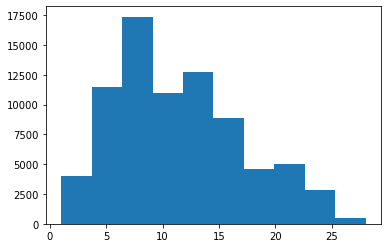

In [30]:
plt.hist(length)

In [24]:
encoder_seq_train = pad_sequences(encoded_docs_train, maxlen=399, dtype='int32', padding='post')
encoder_seq_test = pad_sequences(encoded_docs_test, maxlen=399, dtype='int32', padding='post')
# decoder_out_seq = pad_sequences(encoded_out, maxlen=371, dtype='int32', padding='post')

In [25]:
encoder_seq_train

array([[  344,     6,  5731, ...,     0,     0,     0],
       [    4,   609,    10, ...,     0,     0,     0],
       [   69,   122,   893, ...,     0,     0,     0],
       ...,
       [    1, 20821,    17, ...,     0,     0,     0],
       [  706,     1,  7810, ...,     0,     0,     0],
       [   21,  3384,  3278, ...,     0,     0,     0]])

In [31]:
del encoded_docs_train, encoded_docs_test

## making embded matrix for english text data and for hindi text we will use trainable embedding layer in network itself

In [32]:
embeddings_index = dict()
f = open('D://glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [154]:
sd=embeddings_index.get('eos')
print(sd)

[-0.66432   0.012997  0.01181  -0.084488 -0.78247   1.1457    0.25839
 -0.6626   -1.1347   -0.83052   1.4438   -0.17832   0.52204   0.087625
  0.098307 -0.70804   0.058561  0.40312   0.72853   0.15914   0.0672
  0.016688 -0.52523   0.85851   0.85145  -0.11051   1.0307   -0.17542
 -0.2927   -0.59956  -0.24308   1.2302   -0.81797   0.46934   0.20564
 -0.25792   0.77917  -0.60109   1.4014   -0.5972   -0.40991   0.38727
  0.027353 -0.054872 -0.17931  -0.99247   0.27762  -0.20651  -0.72933
  0.35249  -0.089301  0.81046   0.95734  -0.49469  -0.41374   0.71049
 -0.8651    1.2328    0.14062  -1.0762    0.45116   0.20948  -0.49114
 -0.091184 -1.1643    0.3087   -0.78891  -0.50382  -0.089517  0.44128
  0.83588  -0.089127  0.31822  -0.59513  -0.28502  -1.7288   -0.69524
 -0.023866 -0.7321   -0.5406    0.081562  0.063065  1.4587   -0.017455
  0.11111   0.71711   0.21097  -0.22816   0.57031   1.2428    0.34171
  0.31544   0.18129   0.15407  -0.094941  0.049125  0.68225  -0.14102
  1.2634   -0.44775

In [33]:
eng_inp_vocab_size=max(t_enc_inp.index_word.keys())
embedding_matrix = np.zeros((eng_inp_vocab_size+1, 100))
for word, i in t_enc_inp.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [34]:
embedding_matrix.shape

(41168, 100)

In [35]:
t_dec_out = Tokenizer()
# fit the tokenizer on the documents
sd=t_dec_out.fit_on_texts(train['hindi_sentence'].values)

encoded_docs_train = t_dec_out.texts_to_sequences(train['hindi_sentence'].values)
# encoded_docs_test = t_dec_out.texts_to_sequences(test['hindi_sentence'].values)

In [36]:
len(t_dec_out.index_word.keys())

45243

In [37]:
vocab_hindi=max(t_dec_out.index_word.keys())

In [38]:
max(t_dec_out.index_word.keys())

45243

In [39]:
length=[len(i) for i in encoded_docs_train]

(array([ 4027.,  9502., 15061., 10208., 12603.,  9464.,  5118.,  6360.,
         4763.,  1164.]),
 array([ 2. ,  4.7,  7.4, 10.1, 12.8, 15.5, 18.2, 20.9, 23.6, 26.3, 29. ]),
 <BarContainer object of 10 artists>)

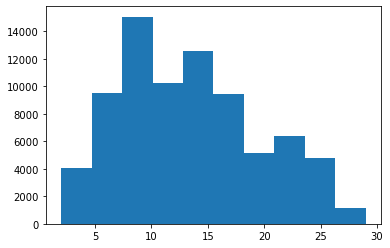

In [40]:
plt.hist(length)

## making dataloader to inputing input_encoder, input_decoder and output_decoder to model

In [49]:
class Dataset:
    def __init__(self, data, embedding,tokenizer_eng,tokenizer_hin,max_len,vocab_hindi):
        self.encoder_inps = data['english_sentence'].values
#         self.decoder_inps = data['decoder_input_hin'].values
        self.decoder_outs = data['hindi_sentence'].values
        self.embedding = embedding
#         self.embedding1 = embedding1
        self.tknizer_eng = tokenizer_eng
#         self.tknizer_hin_inp = tokenizer_hin_inp
        self.tknizer_hin = tokenizer_hin
        self.max_len = max_len
        self.vocab_hindi=vocab_hindi

    def __getitem__(self, i):
        
        
        
        self.encoder_seq = self.tknizer_eng.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
#         self.decoder_inp_seq = self.tknizer_hin_inp.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_inp_seq = self.tknizer_hin.texts_to_sequences([self.decoder_outs[i]])
#         print(self.decoder_inp_seq)
        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq1 = pad_sequences([self.decoder_inp_seq[0][0:len(self.decoder_inp_seq[0])-1]], maxlen=25, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences([self.decoder_inp_seq[0][1:]], maxlen=25, dtype='int32', padding='post')
        #print(self.decoder_inp_seq1)
        #print(self.decoder_out_seq)
        #print(self.encoder_seq)
        self.encoder_seq1=[]
        for i in self.encoder_seq[0]:
            self.encoder_seq1.append(self.embedding[i])
        #print(np.array(encoder_seq1).shape)    
        
#         decoder_inp_seq1 =[]
        
#         for i in self.decoder_inp_seq[0]:
#             decoder_inp_seq1.append(self.embedding1[i])
            
#         self.decoder_out_seq1 = np.zeros((25,self.vocab_hindi+1),dtype=np.float32)
        
#         for i,d in enumerate(self.decoder_out_seq[0]):
#             self.decoder_out_seq1[i,d]=1
        
        
        
        #print(self.encoder_seq.shape)
        return np.array(self.encoder_seq1), self.decoder_inp_seq1, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        #print(dataset)
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))
        #print(self.indexes)


    def __getitem__(self, i):
        #print(i,'in dataloader')
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            #print(self.dataset[j])
            data.append(self.dataset[j])
            #break
        #print(len(data),'in dataloader')
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
#         print(batch[2].shape)
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],tf.squeeze(batch[1])],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [50]:
train_dataset = Dataset(train, embedding_matrix, t_enc_inp,t_dec_out,25,vocab_hindi)
test_dataset  = Dataset(test, embedding_matrix, t_enc_inp,t_dec_out,25,vocab_hindi)

train_dataloader = Dataloder(train_dataset, batch_size=32)
test_dataloader = Dataloder(test_dataset, batch_size=32)
train_dataloader[0]

([array([[[-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
            0.82779998,  0.27061999],
          [-0.12743001,  0.43527001,  0.86000001, ..., -0.24033   ,
            0.37498   ,  0.67258   ],
          [-0.094451  , -0.0096052 ,  0.1793    , ...,  0.21709   ,
           -0.046804  ,  0.13551   ],
          ...,
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.        ]],
  
         [[-0.90959001, -0.64754999,  0.15941   , ...,  0.14275999,
           -0.096841  , -0.25395   ],
          [-0.54263997,  0.41475999,  1.03219998, ..., -1.29690003,
            0.76217002,  0.46349001],
          [-0.27085999,  0.044006  , -0.02026   , ..., -0.4923    ,
            0.63687003,  0.23642001],
          ...,
          [ 

In [35]:
data=[(np.zeros((399,100)),np.zeros((418,67427)),np.zeros((418,67427))),(np.zeros((399,100)),np.zeros((418,67427)),np.zeros((418,67427)))]
for i in zip(*data):
    print(np.stack(i, axis=0).shape)

(2, 399, 100)
(2, 418, 67427)
(2, 418, 67427)


## making a simple model

In [51]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, 25))
encoder = keras.layers.LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(25))
dec_emb_layer = Embedding(vocab_hindi+1,100,input_length=25)(decoder_inputs)
print(dec_emb_layer.shape)

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(64, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb_layer, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(vocab_hindi+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

(None, 25, 100)


In [52]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None, 25)]   0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 100)      4524400     input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 64), (None,  23040       input_3[0][0]                    
____________________________________________________________________________________________

In [49]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## training the model

In [53]:
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    train_dataloader,
    epochs=5,
    validation_data=test_dataloader,
    )

Epoch 1/5
2445/2445 [==============================] - 483s 198ms/step - loss: 3.5919 - accuracy: 0.1267 - val_loss: 3.0692 - val_accuracy: 0.1241
Epoch 2/5
2445/2445 [==============================] - 485s 198ms/step - loss: 3.0757 - accuracy: 0.1195 - val_loss: 2.9041 - val_accuracy: 0.1203
Epoch 3/5
2445/2445 [==============================] - 486s 199ms/step - loss: 2.9061 - accuracy: 0.1169 - val_loss: 2.8019 - val_accuracy: 0.1174
Epoch 4/5
2445/2445 [==============================] - 487s 199ms/step - loss: 2.7661 - accuracy: 0.1144 - val_loss: 2.7260 - val_accuracy: 0.1154
Epoch 5/5
2445/2445 [==============================] - 487s 199ms/step - loss: 2.6480 - accuracy: 0.1130 - val_loss: 2.6717 - val_accuracy: 0.1144


# Attention model

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        self.inp_vocab_size=inp_vocab_size
        self.embedding_size=embedding_size
        self.lstm_size=lstm_size
        self.input_length=input_length
        
        self.embedding=Embedding(self.inp_vocab_size,self.embedding_size,input_length=self.input_length)
        self.lstm=LSTM(self.lstm_size,return_state=True,return_sequences=True)

    def call(self,input_sequence,states):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      embedding1=self.embedding(input_sequence)
      # print('embedding in encoder---',embedding1.shape)
      self.lstm1,self.h_state,self.c_state=self.lstm(embedding1)
      # print('self.lstm1 in encoder---',self.lstm1.shape)
      # print('self.h_state in encoder---',self.h_state.shape)
      # print('self.c_state in encoder---',self.c_state.shape)
      return self.lstm1,self.h_state,self.c_state

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.hid_state=np.zeros((batch_size,self.lstm_size))
      self.cell_state=np.zeros((batch_size,self.lstm_size))
      return self.hid_state,self.cell_state
      

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()

    # Please go through the reference notebook and research paper to complete the scoring functions
    self.att_units=att_units
    self.scoring_function=scoring_function
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      # self.softmax=Softmax(axis=1)
      pass

      
      
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      self.dense1=Dense(self.att_units,activation=None)
      # self.softmax1=Softmax(axis=1)
      
    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      self.dense2=Dense(self.att_units,activation=None)
      self.dense3=Dense(self.att_units,activation=None)
      self.dense4=Dense(1,activation=None)
      
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=1)
    if self.scoring_function == 'dot':
        score = tf.matmul(decoder_hidden_state, encoder_output, transpose_b=True)
        # print(score.shape,'score')
        score = tf.transpose(score,[0,2,1])
        # print(score.shape,'score')
        attention_weights = tf.math.softmax(score,axis=1)
        # print(attention_weights.shape,'attention_weights')
        
        
        # print(encoder_output.shape,'encoder_output')
        # print(decoder_hidden_state.shape,'decoder_hidden_state')
        
        
        # print(attention_weights.shape,'attention_weights')
        context_vector=tf.matmul(attention_weights,encoder_output, transpose_a=True)
        # print(context_vector.shape,'context_vector')
        # context_vector = tf.transpose(context_vector,[0,2,1])
        # print(context_vector.shape,'context_vector')
        context_vector=tf.squeeze(context_vector,axis=1)
        # print(context_vector.shape,'context_vector')
        
          
        
        return context_vector,attention_weights

        
    elif self.scoring_function == 'general':
        
        output1=self.dense1(encoder_output)
        score = tf.matmul(output1,decoder_hidden_state, transpose_b=True)
        # score = tf.transpose(score,[0,2,1])
        # print(score.shape,'score')
        attention_weights = tf.math.softmax(score,axis=1)
        context_vector=tf.matmul(attention_weights,encoder_output, transpose_a=True)
        #context_vector = tf.transpose(context_vector,[0,2,1])
        context_vector=tf.squeeze(context_vector,axis=1)
          
        return context_vector,attention_weights

    
    elif self.scoring_function == 'concat':
    #     # Implement General score function here
          concat1=self.dense2(encoder_output)
          concat2=self.dense3(decoder_hidden_state)
          # concat2=tf.repeat(concat2,)
          concat1=tf.transpose(concat1,[1,0,2])
          concat2=tf.transpose(concat2,[1,0,2])
          # print(concat1.shape,concat2.shape)
          #concat = tf.map_fn(lambda x: tf.add(x, concat2), concat1)
          concat=tf.transpose(tf.multiply(concat2,concat1),[1,0,2])
          concat=tf.math.tanh(concat)
          attention_weights=self.dense4(concat)
          # print(attention_weights.shape)
          context_vector=tf.matmul(attention_weights,encoder_output, transpose_a=True)
          #context_vector = tf.transpose(context_vector,[0,2,1])
          context_vector=tf.squeeze(context_vector,axis=1)
          # print(context_vector.shape,'context_vector')
          return context_vector,attention_weights
    
    

In [ ]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      #Initialize Embedding layer
      #Intialize Encoder LSTM layer
      self.inp_vocab_size=tar_vocab_size
      self.embedding_size=embedding_dim
      self.lstm_size=dec_units
      self.input_length=input_length
      self.att_units=att_units
      self.score_fun=score_fun
      
      self.embedding=Embedding(self.inp_vocab_size,self.embedding_size,input_length=self.input_length)
      self.lstm=LSTM(self.lstm_size,return_state=True,return_sequences=True)
      self.attention=Attention(self.score_fun,self.att_units)
      self.dense=Dense(self.inp_vocab_size,activation='relu')
      self.concat=tf.keras.layers.Concatenate()


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B

    '''
    embedding_out=self.embedding(input_to_decoder)
    
    self.context_vector,self.attention_weights=self.attention(state_h,encoder_output)
    
    concat_vec=self.concat((embedding_out,tf.expand_dims(self.context_vector,axis=1)))
    
    self.lstm1,self.h_state,self.c_state=self.lstm(concat_vec,initial_state=[state_h,state_c])
    #print(self.lstm1.shape,'self.lstm1.shape')
    output=self.dense(self.lstm1)
    #print(output.shape,'output.shape')
    output=tf.squeeze(output,axis=1)
    #print(output.shape,'output.shape')
    
    return output,self.h_state,self.c_state,self.attention_weights,self.context_vector



In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      #Initialize Embedding layer
      #Intialize Encoder LSTM layer
      self.inp_vocab_size=out_vocab_size
      self.embedding_dim=embedding_dim
      self.lstm_size=dec_units
      self.input_length=input_length
      self.att_units=att_units
      self.score_fun=score_fun

      self.onestepdecoder=One_Step_Decoder(self.inp_vocab_size, self.embedding_dim, self.input_length, self.lstm_size ,self.score_fun ,self.att_units)



        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        # print(input_to_decoder.shape,'input_to_decoder.shape')
        all_outputs=tf.TensorArray(tf.float32,tf.shape(input_to_decoder)[1],name='output_arrays')
        #print(input_to_decoder.shape,'input_to_decoder')
        for i in range(tf.shape(input_to_decoder)[1]):
          # print(input_to_decoder[:,i:i+1],'input_to_decoder[:,i:i+1]')
          output,decoder_hidden_state,decoder_cell_state,attention_weights,context_vector=self.onestepdecoder(input_to_decoder[:,i:i+1],encoder_output,decoder_hidden_state,decoder_cell_state)
          all_outputs=all_outputs.write(i,output)
        # print(np.array(all_outputs).shape,'np.array(all_outputs).shape')  
        all_outputs=tf.transpose(all_outputs.stack(),[1,0,2])  
        # print(all_outputs.shape,'all_outputs.shape')  
        return all_outputs
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,inp_vocab_size,embedding_size,lstm_size,encoder_input_length,out_vocab_size, decoder_input_length, dec_units ,score_fun ,att_units):

    # self,out_vocab_size, decoder_input_length, dec_units ,score_fun ,att_units
    #Intialize objects from encoder decoder
    super().__init__()
    #Create encoder object
    #Create decoder object
    #Intialize Dense layer(out_vocab_size) with activation='softmax'
    # self.embedding=Embedding(out_vocab_size,embedding_size,input_length=decoder_input_length)
    self.encoder=Encoder(inp_vocab_size,embedding_size=embedding_size,lstm_size=lstm_size,input_length=encoder_input_length)
    self.decoder=Decoder(out_vocab_size,embedding_dim=embedding_size,input_length=decoder_input_length,dec_units=dec_units,score_fun=score_fun,att_units=att_units)
    
    # self.dense=Dense(output_length,activation='softmax')
    
  def call(self,data):
    input,output=data[0],data[1]
    #print(input[0])

    #print('Input---',input.shape)
    #print('output---',output.shape)
    
    enc_output, encoder_h, encoder_c=self.encoder(input,'kjl')

    # print('enc_output---',enc_output.shape)
    # print('encoder_h---',encoder_h.shape)
    # print('encoder_c---',encoder_c.shape)

    # embeddings1=self.embedding(enc_output)

    # print('embeddings1----',embeddings1.shape)

    decoder_output=self.decoder(output,enc_output,encoder_h,encoder_c)
    
    # print('decoder_output---',decoder_output.shape)

    return decoder_output
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output